# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Jingwei Hu, Tianru Zhang, David Vävinggren

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Emmanuella Ametsi, Yi Peng</font>

- **Team ID:** <font color='red'>emman_yi</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/54581/assignments

**Due Date:** August 22, 2025.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [1]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

Cloning into 'req'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (3/3), done.


In [ ]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 45.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.0 MB/s eta 0:00:00
Reason for being yanked: So that users won't accidentally install this when using python 3.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.3/197.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.1 MB/s et

In [3]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [4]:
# 1. Download dataset
file_name = Path("codesubset.tar.gz")

if not file_name.exists():
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

--2025-07-03 11:16:24--  https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/k4v4u6ypfyfrdjwvykikr/codesubset.tar.gz?rlkey=izu84k9fv82sto7zzl4z769zj&dl=0 [following]
--2025-07-03 11:16:24--  https://www.dropbox.com/scl/fi/k4v4u6ypfyfrdjwvykikr/codesubset.tar.gz?rlkey=izu84k9fv82sto7zzl4z769zj&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccc269ae731a3e6cdb15855007f.dl.dropboxusercontent.com/cd/0/inline/Cszjt7WtpkIAtzxPIQbIbiR9SVTLfoXEnz02oP8QaPjWzDpqTSQpf9x_G5FkFAu65URKNFrQtH1I--tpG9pCX3mkt2VafhCC61-1FXSPzhthCh9GqwucAC62UtfymDsrMDI/file# [following]
--2025-07-03 11:16:25--  https://uccc269ae731a3e6cdb15855007f.dl.dropboxusercontent.com/cd/0

In [5]:
# 1. unzip the downloaded data set folder
file_name = Path('codesubset')
if not file_name.exists():
    !tar -xf codesubset.tar.gz

Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [6]:
# 2. clone the code files for data preprocessing
file_name = Path('ecg-preprocessing')
if not file_name.exists():
    !git clone https://github.com/paulhausner/ecg-preprocessing.git

Cloning into 'ecg-preprocessing'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 19), reused 32 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 386.28 KiB | 11.71 MiB/s, done.
Resolving deltas: 100% (19/19), done.


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

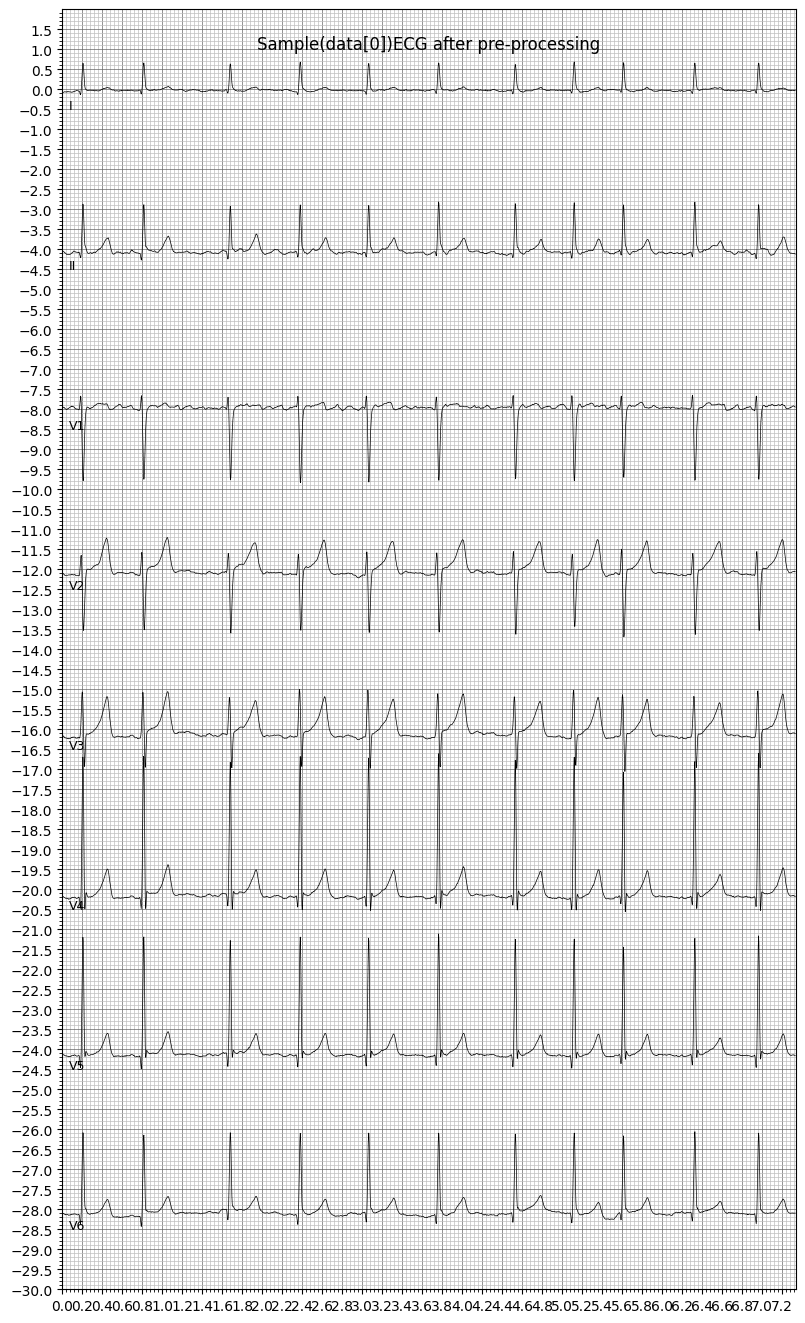

In [7]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample(data[0])ECG after pre-processing')
plt.show()

#


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

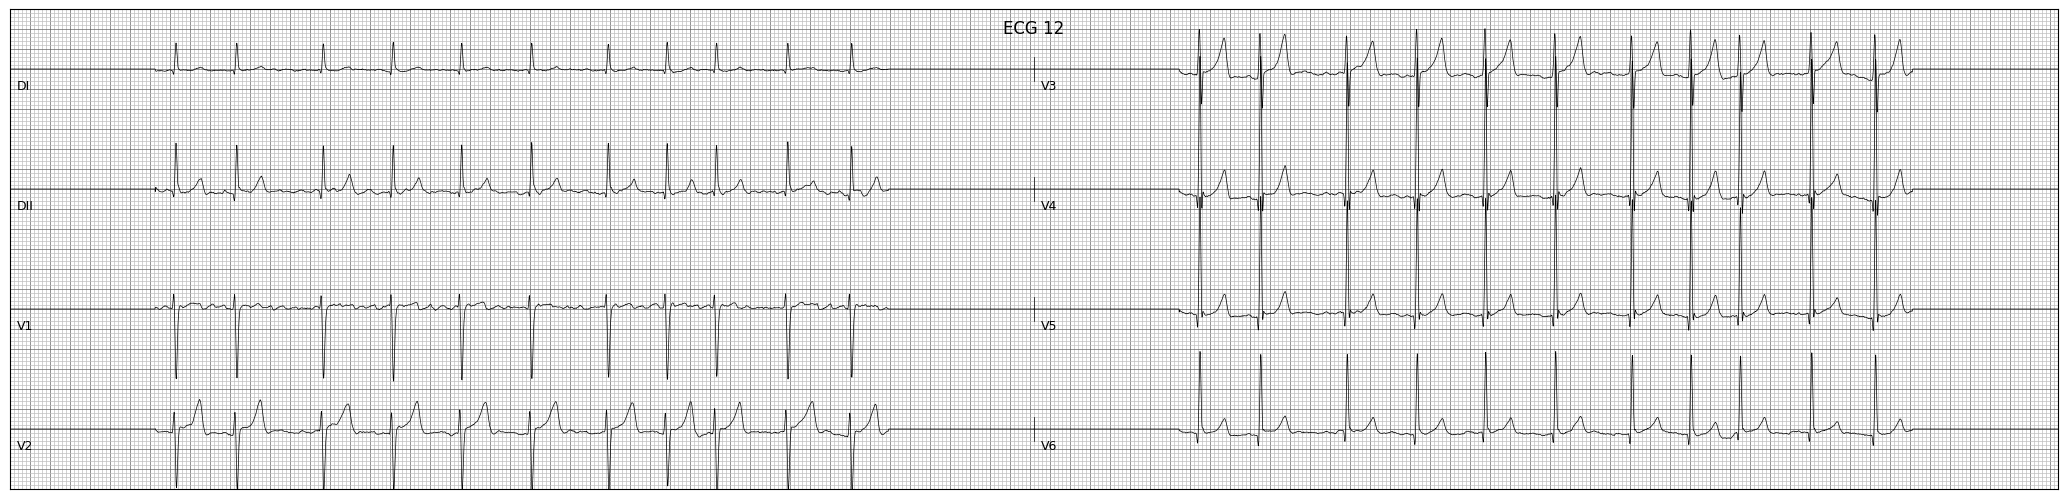

<Figure size 640x480 with 0 Axes>

In [8]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [9]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(input_file='codesubset/train/RECORDS.txt', out_file='codesubset/train.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 10000/10000 [00:56<00:00, 177.22it/s]
Namespace(input_file='codesubset/test/RECORDS.txt', out_file='codesubset/test.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 6000/6000 [00:33<00:00, 176.97it/s]


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


(10000, 4096, 8)
(4096, 8)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

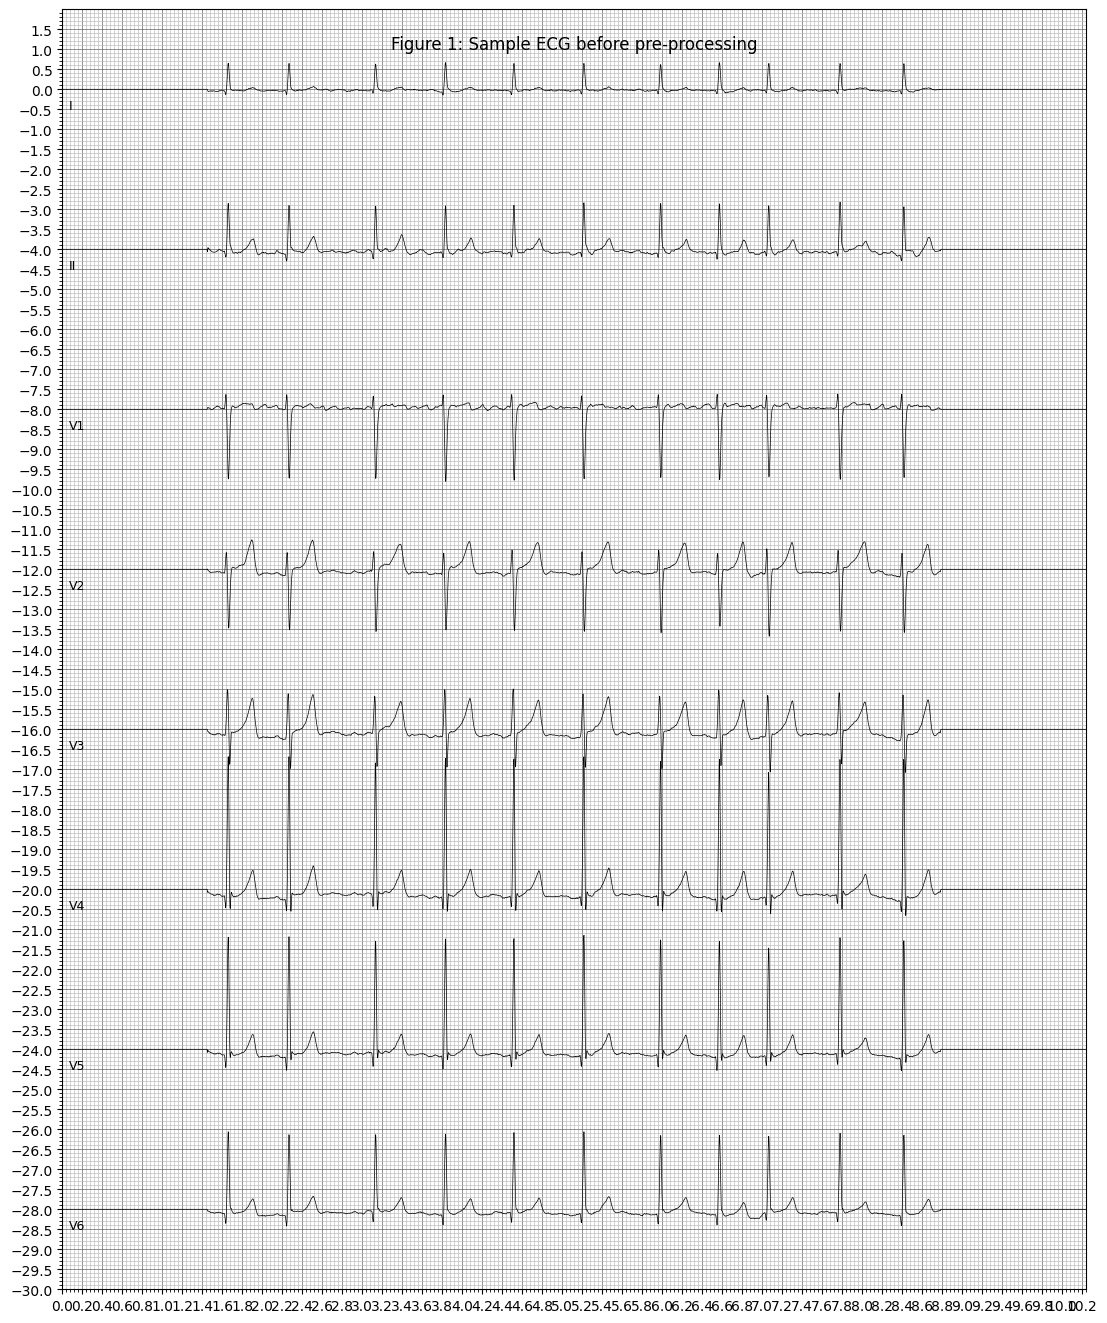

Distribution of Atrial Fibrillation (AF) in the dataset:
AF
0    7000
1    3000
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

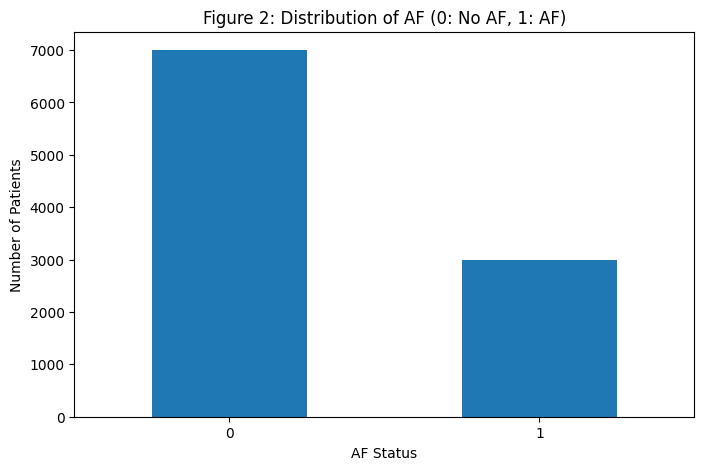

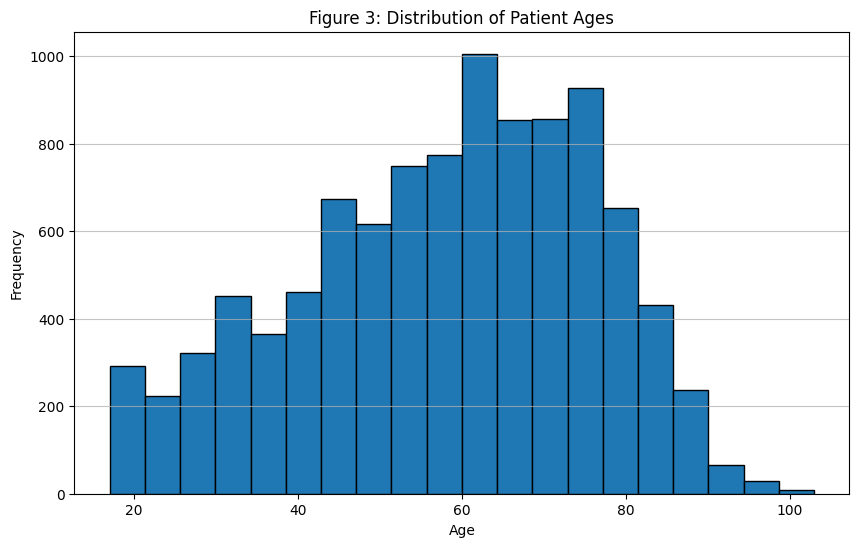

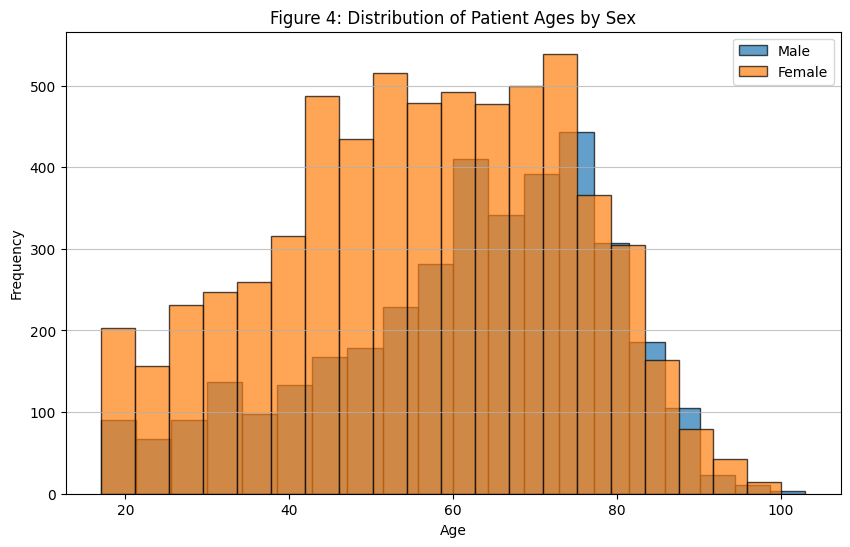

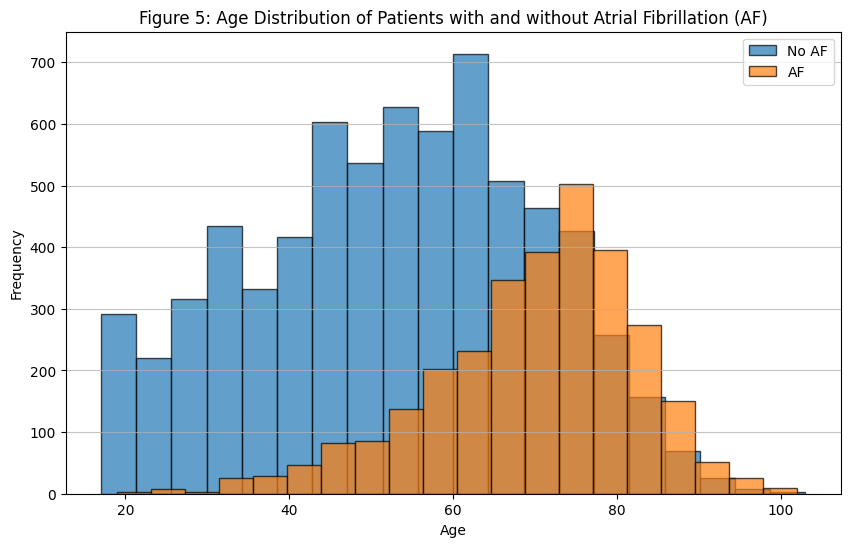

'\nEnd of our code.\n'

In [10]:
"""
TASK: Insert your code here
"""

import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
print(data.shape)
print(data[1].shape)


#Plot for an ECG example after preprocessing
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(data[0].T, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Figure 1: Sample ECG before pre-processing')
plt.show()

#Reading patient data from csv
patient_data = pd.read_csv('codesubset/train.csv')

#To check balance of dataset, we do plot the distribution of Atrial Fibrillation (AF) in the dataset
af_counts = patient_data['AF'].value_counts()
print("Distribution of Atrial Fibrillation (AF) in the dataset:")
print(af_counts)

# You can also visualize this with a bar plot
plt.figure(figsize=(8, 5))
af_counts.plot(kind='bar')
plt.title('Figure 2: Distribution of AF (0: No AF, 1: AF)')
plt.xlabel('AF Status')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

#Evaluating the distribution of age and sex of the patients using histograms

plt.figure(figsize=(10, 6))
plt.hist(patient_data['age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 3: Distribution of Patient Ages')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(patient_data[patient_data['sex'] == 'M']['age'], bins=20, edgecolor='black', alpha=0.7, label='Male')
plt.hist(patient_data[patient_data['sex'] == 'F']['age'], bins=20, edgecolor='black', alpha=0.7, label='Female')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 4: Distribution of Patient Ages by Sex')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

#Evaluating the distribution of patients with and without Atrial Fibrillation (AF)

plt.figure(figsize=(10, 6))
plt.hist(patient_data[patient_data['AF'] == 0]['age'], bins=20, edgecolor='black', alpha=0.7, label='No AF')
plt.hist(patient_data[patient_data['AF'] == 1]['age'], bins=20, edgecolor='black', alpha=0.7, label='AF')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 5: Age Distribution of Patients with and without Atrial Fibrillation (AF)')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

"""
End of our code.
"""

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

What preprocessing does and why it is necessary :
  * The data is resampled at 400HZ so that it captures important frequencies while reducing computational cost and keeping the data volume managable. It is a standard proceedure according to the National Instituite of Health(NIH) and GE Healthcare.
  * Some signals had different durations and in order to make them all have the same sizes, zero-padding was done.
  * According to the original [article](https://www.nature.com/articles/s41467-020-15432-4), removing trends in ECG signals/removing possible powerline noise was done because noise and interference in the baseline are established causes of error and affects both automatic and manual diagnosis of ECG abnomalities.



Main findings from our data analysis:
  * We checked the balance of the dataset by  examining the distribution of the target variable AF in figure 2. The distribution shows that there are more patients without AF than patients with AF and this could be a point of concern for training.

  * We also evaluated the distribution of the ages and sexs of patients in using histograms in figure 3 and 4. We noticed that there are more female patients than males(fig3) and the majority of patients are between 40 to 80 years old.

  * We analysed the age distribution of patients with and without Atrial Fibrillation (AF) in figure 5 and noticed that more older patients tend to have AF than younger ones.






---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [11]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [29]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        """
        TASK: Replace the baseline model with your model; Insert your code here
        """
        self.kernel_size = 3

        # The first convolutional layer downsamples the sequence length
        downsample1 = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(
            in_channels=8,
            out_channels=32,
            kernel_size=self.kernel_size,
            stride=downsample1,
            padding=self._padding(downsample1),
            bias=False
        )

        # Shape after conv1: (batch_size, 32, 128)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)

        # The second convolutional layer uses a stride of 2
        downsample2 = 2
        self.conv2 = nn.Conv1d(
            in_channels=32,
            out_channels=64,
            kernel_size=self.kernel_size,
            stride=downsample2,
            padding=self._padding(downsample2),
            bias=False
        )
        # Shape after conv2: (batch_size, 64, 64)  (128 / 2 = 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)

        # --- Fully Connected Layers ---
        # The input features for the linear layer depend on the output shape of the last convolutional layer.
        # Output shape after conv2 is (batch_size, 64, 64)
        # self.flatten_features = 64 * 64 # out_channels_conv2 * final_sequence_length
        # Corrected calculation for flatten_features based on the output shape of conv2
        self.flatten_features = 64 * ((128 - self._padding(downsample2) * 2 - (self.kernel_size - 1) - 1) // downsample2 + 1)


        self.fc1 = nn.Linear(in_features=self.flatten_features, out_features=128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        # --- Output Layer ---
        self.fc2 = nn.Linear(in_features=128, out_features=1)



    def _padding(self, downsample):
        # Simplified padding calculation for stride 1 or 2
        return max(0, (self.kernel_size - downsample) // 2)


    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)

    def forward(self, x):
        x = x.transpose(1, 2)

        # Pass through convolutional blocks
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        #x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        #x = self.pool2(x)

        # Flatten the features for the fully connected layers
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)
        #x = self.sigmoid(x)

        return x
        """
        End of our code.
        """

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [13]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        output = model(traces)
        loss = loss_function(output, diagnoses)
        loss.backward()
        optimizer.step()

        """
        End of our code.
        """

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    print(f'loss:{total_loss/32}')
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [14]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_probs = []  # accumulated predicted probabilities
    valid_true = [] # accumulated true labels

    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
          output = model(traces)
          loss = loss_function(output, diagnoses)

          # Convert logits to probabilities for evaluation
          probs = torch.sigmoid(output)

          # Collect true labels and predicted probabilities
          valid_true.extend(diagnoses.cpu().numpy())
          valid_probs.extend(probs.squeeze(1).cpu().numpy())

        """
        End of our code.
        """

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_probs), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**


In [24]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-3
weight_decay = 1e-3
num_epochs = 80
batch_size = 32

In [22]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
train_size = int(0.8 * len_dataset)
valid_size = len_dataset - train_size
dataset_train, dataset_valid = random_split(dataset, [train_size, valid_size])
"""
End of our code.
"""

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
Done!



Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/80 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

loss:4.116883131675422


Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.016468 	Valid Loss 0.013436 	AUROC 0.8595 	AP 0.6946 	F1 0.4568 	Best model -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.4031986403279006


Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.013613 	Valid Loss 0.012547 	AUROC 0.8768 	AP 0.7455 	F1 0.4568 	Best model -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.2760517154820263


Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.013104 	Valid Loss 0.012673 	AUROC 0.8856 	AP 0.7636 	F1 0.4568 	


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.1365539100952446


Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.012546 	Valid Loss 0.012134 	AUROC 0.8877 	AP 0.7668 	F1 0.4568 	Best model -> saved


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.999392314814031


Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.011998 	Valid Loss 0.011895 	AUROC 0.8931 	AP 0.7688 	F1 0.4568 	Best model -> saved


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.8620760631747544


Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.011448 	Valid Loss 0.010988 	AUROC 0.9098 	AP 0.8013 	F1 0.4568 	Best model -> saved


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7324767862446606


Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.010930 	Valid Loss 0.010606 	AUROC 0.9154 	AP 0.8085 	F1 0.4568 	Best model -> saved


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7055671776179224


Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.010822 	Valid Loss 0.010658 	AUROC 0.9161 	AP 0.8089 	F1 0.4568 	


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6407077990006655


Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.010563 	Valid Loss 0.011190 	AUROC 0.9171 	AP 0.8156 	F1 0.4568 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.518394199665636


Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.010074 	Valid Loss 0.010275 	AUROC 0.9249 	AP 0.8407 	F1 0.4568 	Best model -> saved


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.459932406898588


Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.009840 	Valid Loss 0.010140 	AUROC 0.9288 	AP 0.8262 	F1 0.4568 	Best model -> saved


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.4530636593699455


Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.009812 	Valid Loss 0.009520 	AUROC 0.9357 	AP 0.8649 	F1 0.4568 	Best model -> saved


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.334962143097073


Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.009340 	Valid Loss 0.009377 	AUROC 0.9371 	AP 0.8632 	F1 0.4568 	Best model -> saved


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.2785447612404823


Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.009114 	Valid Loss 0.009231 	AUROC 0.9368 	AP 0.8547 	F1 0.4568 	Best model -> saved


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.195803761249408


Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.008783 	Valid Loss 0.008857 	AUROC 0.9428 	AP 0.8726 	F1 0.4568 	Best model -> saved


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.174360337899998


Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: 	Train Loss 0.008697 	Valid Loss 0.009119 	AUROC 0.9453 	AP 0.8749 	F1 0.4568 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.1818087880965322


Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: 	Train Loss 0.008727 	Valid Loss 0.009115 	AUROC 0.9427 	AP 0.8853 	F1 0.4568 	


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.180544084403664


Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: 	Train Loss 0.008722 	Valid Loss 0.008802 	AUROC 0.9474 	AP 0.8879 	F1 0.4568 	Best model -> saved


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.077333902940154


Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: 	Train Loss 0.008309 	Valid Loss 0.008808 	AUROC 0.9433 	AP 0.8779 	F1 0.4568 	


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.015875965123996


Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: 	Train Loss 0.008064 	Valid Loss 0.008464 	AUROC 0.9494 	AP 0.8904 	F1 0.4568 	Best model -> saved


Training Epoch 21:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9583681777585298


Evaluation Epoch 21:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21: 	Train Loss 0.007833 	Valid Loss 0.008855 	AUROC 0.9461 	AP 0.8849 	F1 0.4568 	


Training Epoch 22:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.0294279190711677


Evaluation Epoch 22:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22: 	Train Loss 0.008118 	Valid Loss 0.008773 	AUROC 0.9510 	AP 0.8966 	F1 0.4568 	


Training Epoch 23:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9234550560358912


Evaluation Epoch 23:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23: 	Train Loss 0.007694 	Valid Loss 0.008475 	AUROC 0.9492 	AP 0.8830 	F1 0.4568 	


Training Epoch 24:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.961820892058313


Evaluation Epoch 24:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24: 	Train Loss 0.007847 	Valid Loss 0.007877 	AUROC 0.9553 	AP 0.9028 	F1 0.4568 	Best model -> saved


Training Epoch 25:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.8375950059853494


Evaluation Epoch 25:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25: 	Train Loss 0.007350 	Valid Loss 0.007937 	AUROC 0.9552 	AP 0.8941 	F1 0.4568 	


Training Epoch 26:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9082442573271692


Evaluation Epoch 26:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26: 	Train Loss 0.007633 	Valid Loss 0.007853 	AUROC 0.9582 	AP 0.9112 	F1 0.4568 	Best model -> saved


Training Epoch 27:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.807212658575736


Evaluation Epoch 27:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27: 	Train Loss 0.007229 	Valid Loss 0.008198 	AUROC 0.9521 	AP 0.8985 	F1 0.4562 	


Training Epoch 28:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.7509296156931669


Evaluation Epoch 28:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28: 	Train Loss 0.007004 	Valid Loss 0.007728 	AUROC 0.9574 	AP 0.9104 	F1 0.4568 	Best model -> saved


Training Epoch 29:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.7791905181948096


Evaluation Epoch 29:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29: 	Train Loss 0.007117 	Valid Loss 0.008427 	AUROC 0.9544 	AP 0.8936 	F1 0.4568 	


Training Epoch 30:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.789700968656689


Evaluation Epoch 30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30: 	Train Loss 0.007159 	Valid Loss 0.007195 	AUROC 0.9631 	AP 0.9198 	F1 0.4568 	Best model -> saved


Training Epoch 31:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.748427783837542


Evaluation Epoch 31:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31: 	Train Loss 0.006994 	Valid Loss 0.007980 	AUROC 0.9609 	AP 0.9141 	F1 0.4562 	


Training Epoch 32:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.7614571884041652


Evaluation Epoch 32:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32: 	Train Loss 0.007046 	Valid Loss 0.007389 	AUROC 0.9607 	AP 0.9146 	F1 0.4568 	


Training Epoch 33:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.6764653138816357


Evaluation Epoch 33:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33: 	Train Loss 0.006706 	Valid Loss 0.008132 	AUROC 0.9630 	AP 0.9149 	F1 0.4568 	


Training Epoch 34:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.7035994038451463


Evaluation Epoch 34:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34: 	Train Loss 0.006814 	Valid Loss 0.008479 	AUROC 0.9600 	AP 0.9123 	F1 0.4568 	


Training Epoch 35:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.6633896772982553


Evaluation Epoch 35:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35: 	Train Loss 0.006654 	Valid Loss 0.007284 	AUROC 0.9613 	AP 0.9115 	F1 0.4568 	


Training Epoch 36:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.6622470918809995


Evaluation Epoch 36:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36: 	Train Loss 0.006649 	Valid Loss 0.007271 	AUROC 0.9649 	AP 0.9220 	F1 0.4568 	


Training Epoch 37:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.6605755926575512


Evaluation Epoch 37:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37: 	Train Loss 0.006642 	Valid Loss 0.008335 	AUROC 0.9672 	AP 0.9251 	F1 0.4577 	


Training Epoch 38:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.6593021489679813


Evaluation Epoch 38:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38: 	Train Loss 0.006637 	Valid Loss 0.006801 	AUROC 0.9663 	AP 0.9227 	F1 0.4568 	Best model -> saved


Training Epoch 39:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.6399116520769894


Evaluation Epoch 39:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39: 	Train Loss 0.006560 	Valid Loss 0.006932 	AUROC 0.9650 	AP 0.9163 	F1 0.4568 	


Training Epoch 40:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.5855304158758372


Evaluation Epoch 40:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40: 	Train Loss 0.006342 	Valid Loss 0.006930 	AUROC 0.9641 	AP 0.9190 	F1 0.4568 	


Training Epoch 41:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.5886831159004942


Evaluation Epoch 41:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41: 	Train Loss 0.006355 	Valid Loss 0.007549 	AUROC 0.9584 	AP 0.9094 	F1 0.4568 	


Training Epoch 42:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.612707671476528


Evaluation Epoch 42:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42: 	Train Loss 0.006451 	Valid Loss 0.007138 	AUROC 0.9656 	AP 0.9191 	F1 0.4568 	


Training Epoch 43:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.5767257962143049


Evaluation Epoch 43:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43: 	Train Loss 0.006307 	Valid Loss 0.007468 	AUROC 0.9619 	AP 0.9114 	F1 0.4568 	


Training Epoch 44:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.5736516730394214


Evaluation Epoch 44:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44: 	Train Loss 0.006295 	Valid Loss 0.007107 	AUROC 0.9644 	AP 0.9255 	F1 0.4568 	


Training Epoch 45:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.5417215274646878


Evaluation Epoch 45:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45: 	Train Loss 0.006167 	Valid Loss 0.007474 	AUROC 0.9654 	AP 0.9181 	F1 0.4575 	


Training Epoch 46:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.4948839435819536


Evaluation Epoch 46:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46: 	Train Loss 0.005980 	Valid Loss 0.007174 	AUROC 0.9633 	AP 0.9121 	F1 0.4568 	
Epoch 00046: reducing learning rate of group 0 to 1.0000e-04.


Training Epoch 47:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.3870047131204046


Evaluation Epoch 47:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47: 	Train Loss 0.005548 	Valid Loss 0.006951 	AUROC 0.9667 	AP 0.9295 	F1 0.4570 	


Training Epoch 48:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.3022125471616164


Evaluation Epoch 48:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48: 	Train Loss 0.005209 	Valid Loss 0.007218 	AUROC 0.9681 	AP 0.9344 	F1 0.4571 	


Training Epoch 49:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.2172868655761704


Evaluation Epoch 49:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49: 	Train Loss 0.004869 	Valid Loss 0.007179 	AUROC 0.9687 	AP 0.9315 	F1 0.4571 	


Training Epoch 50:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1948782128747553


Evaluation Epoch 50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50: 	Train Loss 0.004780 	Valid Loss 0.007016 	AUROC 0.9678 	AP 0.9307 	F1 0.4571 	


Training Epoch 51:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1528264006483369


Evaluation Epoch 51:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51: 	Train Loss 0.004611 	Valid Loss 0.007133 	AUROC 0.9695 	AP 0.9359 	F1 0.4587 	


Training Epoch 52:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1926793133607134


Evaluation Epoch 52:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52: 	Train Loss 0.004771 	Valid Loss 0.006804 	AUROC 0.9653 	AP 0.9235 	F1 0.4568 	


Training Epoch 53:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1818253205274232


Evaluation Epoch 53:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53: 	Train Loss 0.004727 	Valid Loss 0.006819 	AUROC 0.9695 	AP 0.9338 	F1 0.4575 	


Training Epoch 54:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1461017684196122


Evaluation Epoch 54:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54: 	Train Loss 0.004584 	Valid Loss 0.006547 	AUROC 0.9687 	AP 0.9320 	F1 0.4571 	Best model -> saved


Training Epoch 55:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.2071553555433638


Evaluation Epoch 55:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55: 	Train Loss 0.004829 	Valid Loss 0.006429 	AUROC 0.9708 	AP 0.9378 	F1 0.4573 	Best model -> saved


Training Epoch 56:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.124644041294232


Evaluation Epoch 56:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56: 	Train Loss 0.004499 	Valid Loss 0.006992 	AUROC 0.9713 	AP 0.9391 	F1 0.4587 	


Training Epoch 57:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1548691276693717


Evaluation Epoch 57:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57: 	Train Loss 0.004619 	Valid Loss 0.006357 	AUROC 0.9696 	AP 0.9333 	F1 0.4568 	Best model -> saved


Training Epoch 58:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0986607349477708


Evaluation Epoch 58:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58: 	Train Loss 0.004395 	Valid Loss 0.006680 	AUROC 0.9666 	AP 0.9250 	F1 0.4568 	


Training Epoch 59:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1049983235425316


Evaluation Epoch 59:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59: 	Train Loss 0.004420 	Valid Loss 0.006703 	AUROC 0.9714 	AP 0.9387 	F1 0.4582 	


Training Epoch 60:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.127237521810457


Evaluation Epoch 60:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60: 	Train Loss 0.004509 	Valid Loss 0.006861 	AUROC 0.9725 	AP 0.9376 	F1 0.4580 	


Training Epoch 61:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1525930867064744


Evaluation Epoch 61:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61: 	Train Loss 0.004610 	Valid Loss 0.006707 	AUROC 0.9720 	AP 0.9361 	F1 0.4571 	


Training Epoch 62:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.08718717523152


Evaluation Epoch 62:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62: 	Train Loss 0.004349 	Valid Loss 0.006418 	AUROC 0.9705 	AP 0.9335 	F1 0.4573 	


Training Epoch 63:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0921527610626072


Evaluation Epoch 63:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63: 	Train Loss 0.004369 	Valid Loss 0.006592 	AUROC 0.9711 	AP 0.9349 	F1 0.4580 	


Training Epoch 64:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1015388150699437


Evaluation Epoch 64:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64: 	Train Loss 0.004406 	Valid Loss 0.006554 	AUROC 0.9700 	AP 0.9352 	F1 0.4571 	


Training Epoch 65:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.1224139969563112


Evaluation Epoch 65:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65: 	Train Loss 0.004490 	Valid Loss 0.006947 	AUROC 0.9696 	AP 0.9315 	F1 0.4571 	
Epoch 00065: reducing learning rate of group 0 to 1.0000e-05.


Training Epoch 66:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0866583859897219


Evaluation Epoch 66:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66: 	Train Loss 0.004347 	Valid Loss 0.007470 	AUROC 0.9713 	AP 0.9397 	F1 0.4584 	


Training Epoch 67:   0%|          | 0/250 [00:00<?, ?it/s]

loss:0.9929191274568439


Evaluation Epoch 67:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67: 	Train Loss 0.003972 	Valid Loss 0.006771 	AUROC 0.9709 	AP 0.9378 	F1 0.4573 	


Training Epoch 68:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0435716070933267


Evaluation Epoch 68:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68: 	Train Loss 0.004174 	Valid Loss 0.006956 	AUROC 0.9687 	AP 0.9297 	F1 0.4570 	


Training Epoch 69:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0304770692018792


Evaluation Epoch 69:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69: 	Train Loss 0.004122 	Valid Loss 0.006630 	AUROC 0.9707 	AP 0.9376 	F1 0.4571 	


Training Epoch 70:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0200459971674718


Evaluation Epoch 70:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70: 	Train Loss 0.004080 	Valid Loss 0.006573 	AUROC 0.9710 	AP 0.9386 	F1 0.4580 	


Training Epoch 71:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0360015548649244


Evaluation Epoch 71:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71: 	Train Loss 0.004144 	Valid Loss 0.006677 	AUROC 0.9706 	AP 0.9389 	F1 0.4577 	


Training Epoch 72:   0%|          | 0/250 [00:00<?, ?it/s]

loss:0.99478538276162


Evaluation Epoch 72:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72: 	Train Loss 0.003979 	Valid Loss 0.006471 	AUROC 0.9713 	AP 0.9396 	F1 0.4577 	


Training Epoch 73:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0286860030028038


Evaluation Epoch 73:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73: 	Train Loss 0.004115 	Valid Loss 0.006443 	AUROC 0.9701 	AP 0.9361 	F1 0.4570 	
Epoch 00073: reducing learning rate of group 0 to 1.0000e-06.


Training Epoch 74:   0%|          | 0/250 [00:00<?, ?it/s]

loss:0.9841566415852867


Evaluation Epoch 74:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74: 	Train Loss 0.003937 	Valid Loss 0.006318 	AUROC 0.9701 	AP 0.9364 	F1 0.4571 	Best model -> saved


Training Epoch 75:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.040018064668402


Evaluation Epoch 75:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75: 	Train Loss 0.004160 	Valid Loss 0.006754 	AUROC 0.9709 	AP 0.9391 	F1 0.4577 	


Training Epoch 76:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0036845901049674


Evaluation Epoch 76:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76: 	Train Loss 0.004015 	Valid Loss 0.006438 	AUROC 0.9704 	AP 0.9376 	F1 0.4571 	


Training Epoch 77:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.021269554272294


Evaluation Epoch 77:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77: 	Train Loss 0.004085 	Valid Loss 0.006656 	AUROC 0.9716 	AP 0.9416 	F1 0.4578 	


Training Epoch 78:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0492598738055676


Evaluation Epoch 78:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78: 	Train Loss 0.004197 	Valid Loss 0.006942 	AUROC 0.9671 	AP 0.9249 	F1 0.4568 	


Training Epoch 79:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0520764372486155


Evaluation Epoch 79:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79: 	Train Loss 0.004208 	Valid Loss 0.006606 	AUROC 0.9716 	AP 0.9400 	F1 0.4580 	


Training Epoch 80:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.0480546898324974


Evaluation Epoch 80:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80: 	Train Loss 0.004192 	Valid Loss 0.006505 	AUROC 0.9715 	AP 0.9389 	F1 0.4577 	


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

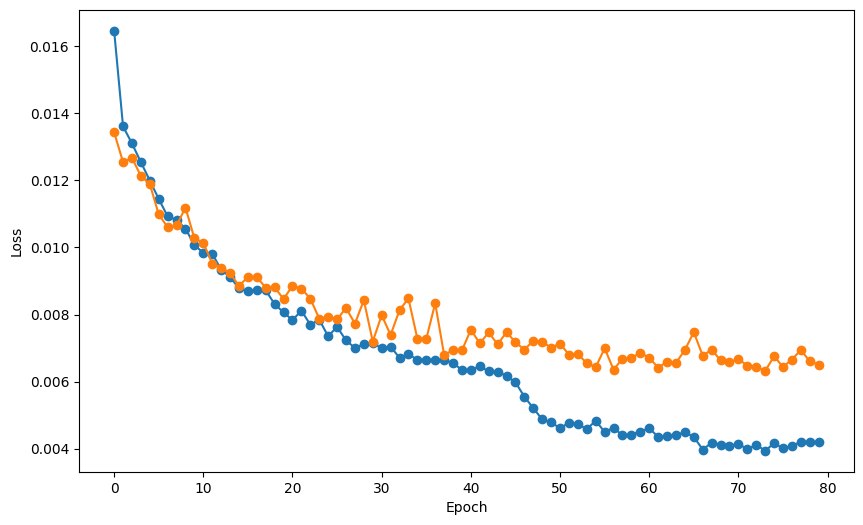

In [30]:
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
#num_positives = torch.sum(labels == 1)
#num_negatives = torch.sum(labels == 0)

#pos_weight = torch.tensor([num_negatives / num_positives], device=device)
#loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_function = nn.BCEWithLogitsLoss()
"""
End of our code.
"""

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      # The scheduler will step when the quantity monitored has stopped decreasing
    factor=0.1,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=7,      # Number of epochs with no improvement after which learning rate will be reduced
    verbose=True     # If True, prints a message to stdout for each update.
)

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

    # Assuming y_pred contains raw logits and y_true contains binary labels (0 or 1)
    # Apply sigmoid to y_pred to get probabilities for the positive class
    y_pred_prob = torch.sigmoid(torch.tensor(y_pred)).numpy()

    # Calculate metrics
    auc = roc_auc_score(y_true, y_pred_prob)
    ap = average_precision_score(y_true, y_pred_prob)

    # For F1 score, we need binary predictions. A common threshold is 0.5
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary)


    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                'AUROC {auc:.4f} \t'
                'AP {ap:.4f} \t'
                'F1 {f1:.4f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        auc=auc,
                        ap=ap,
                        f1=f1,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step(valid_loss)
"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
plt.figure(figsize=(10, 6))
plt.plot(train_loss_all, label='Training Loss', marker='o')
plt.plot(valid_loss_all, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain soft predictions (probabilities) instead of hard predictions (0s or 1s).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The predictions are saved in the variable `soft_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [31]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [32]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [33]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (3/3), done.


In [35]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password.
Do not change this after you have registered your team
"""
team_id = 'emman_yi' #Fill in a string
password = '123456789' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [36]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'bn & drop' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Fill in</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**